<a href="https://colab.research.google.com/github/thxsxth/RLMimic/blob/master/Denoising_GRU_Autoencoder_for_Labs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
cd 'drive/My Drive/sepsis3-cohort'

[Errno 2] No such file or directory: 'drive/My Drive/sepsis3-cohort'
/content/drive/.shortcut-targets-by-id/1Dn0AjHyN50Kv8tcF0f2bQsdPbRYa_49h/sepsis3-cohort


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import numpy as np
import pandas as pd
import datetime as dt
import random
import time
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import os
import glob
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence,pad_packed_sequence
import torch.nn.init as weight_init
import scipy
import matplotlib.pyplot as plt

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'
from load_and_process import *

### Let's try to encode Lab's in a meaningful way

In [ ]:
labs=labs[['ICUSTAY_ID','charttime','ANIONGAP','BICARBONATE',	'CREATININE',	'CHLORIDE',	'GLUCOSE',	'HEMATOCRIT',	
           'HEMOGLOBIN','PLATELET'	,'POTASSIUM',	'SODIUM',	'BUN'	,'WBC']]

In [ ]:
cols=['ANIONGAP','BICARBONATE',	'CREATININE',	'CHLORIDE',	'GLUCOSE',	'HEMATOCRIT',	
           'HEMOGLOBIN','PLATELET'	,'POTASSIUM',	'SODIUM',	'BUN'	,'WBC']
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
labs[cols]=scaler.fit_transform(labs[cols])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [ ]:
scaler.mean_

array([ 13.74881329,  25.25742577,   1.54271023, 103.7340241 ,
       132.71708512,  30.45411086,  10.30417942, 234.57353053,
         4.12252976, 138.55076211,  30.99596446,  11.28530352])

In [ ]:
scaler.var_

array([1.50391034e+01, 2.57841535e+01, 2.49669943e+00, 4.01629934e+01,
       4.55012820e+03, 2.91368547e+01, 3.63294460e+00, 2.43912690e+04,
       4.18357585e-01, 2.69246799e+01, 5.84177732e+02, 8.54082508e+01])

In [ ]:
class labs_dataset(Dataset):
  """
  """
  def __init__(self,patient_ids,train=True,T_max=48):
    #patient_ids :List/np.array
    self.ids=patient_ids
    self.train=train
    self.T_max=T_max

  def __len__(self):
    return len(self.ids)

  def __getitem__(self,idx):
    #Get Patient from the index
    pat=self.ids[idx]
    
    pat_labs=labs[labs.ICUSTAY_ID==pat]
    pat_labs=pat_labs.set_index('charttime').resample('12H').mean().ffill().dropna()

    if co.loc[pat].HOSPITAL_EXPIRE_FLAG==1:
          pat_labs=pat_labs.truncate(after=co.loc[pat].death_time)

  
    # print(pat_df.shape)

    pat_labs=pat_labs.drop(['ICUSTAY_ID'],axis=1)

    # print(pat_labs.columns)
    # constants=torch.FloatTensor(co.loc[pat][['age','is_male']]).to(device)

    T=self.T_max
    if pat_labs.shape[0]>T:
          k=np.random.choice(pat_labs.shape[0]-T)
          pat_labs=pat_labs.iloc[k:k+T,:]


    return torch.FloatTensor(pat_labs.values).to(device)

In [ ]:
def collate_labs(batch_data):

  """
  We will be a list of tuples,
  len(list) will be batch_size

  """
  labs=[]
  seq_lens=[]
 
  for lab in batch_data:

    labs.append(lab)
    seq_lens.append(lab.shape[0])

  
  padded_trajectories=pad_sequence(labs,batch_first=True)
  mask=get_mini_batch_mask(padded_trajectories,seq_lens)
  

  return padded_trajectories,mask,seq_lens


In [ ]:
patient_list=list(np.load('new_pats.npy'))


In [ ]:
training_cohort=np.random.choice(a=patient_list, size=int(0.8*len(patient_list)), replace=False)
train_dataset=labs_dataset(training_cohort,T_max=np.inf)
train_loader=DataLoader(train_dataset,batch_size=16,shuffle=True,collate_fn=collate_labs)

valid_cohort=list(set(patient_list)-set(training_cohort))
valid_dataset=labs_dataset(valid_cohort,T_max=np.inf)
valid_loader=DataLoader(valid_dataset,batch_size=64,shuffle=False,collate_fn=collate_labs)

In [ ]:
class Encoder(nn.Module):
  """ Encodes x_{:t} 
      The job of the Encoder is to remember the past observations.
     
  """

  def __init__(self,input_dim,h_dim,n_layers=12, dropout=0.0):
      
      super(Encoder,self).__init__()
      
      self.rnn=nn.GRU(input_dim,h_dim,n_layers,batch_first=True)
      self.dropout=dropout  
      self.n_layers=n_layers
      self.hidden_dim=h_dim
      self.init_weights()
      

  def  init_weights(self):
        for w in self.rnn.parameters(): # initialize the gate weights with orthogonal
            if w.dim()>1:
                weight_init.orthogonal_(w)

  def forward(self,obs,obs_lens,init_h=None, noise=False):

    
    batch_size, max_len, freq=obs.size()  
    obs_lens=torch.LongTensor(obs_lens).to(device)
    obs_lens_sorted, indices = obs_lens.sort(descending=True)
    obs_sorted = obs.index_select(0, indices).to(device)
    
    packed_obs=pack_padded_sequence(obs_sorted,obs_lens_sorted.data.tolist(),batch_first=True)
    # if init_h is None:
    #     init_h=self.init_h

     
    
    hids, h_n = self.rnn(packed_obs) # hids: [B x T x H]  
                                                  # h_n: [num_layers*B*H)
    _, inv_indices = indices.sort()

    hids, lens = pad_packed_sequence(hids, batch_first=True)         
    hids = hids.index_select(0, inv_indices) #B*T*H
    
    
            
    return hids

In [ ]:
class stacked_autoencoder(nn.Module):

  def __init__(self,input_dim,h_dims=[512,128,10],n_layers=[12,8,3]):
    
    super(stacked_autoencoder,self).__init__()   
    self.encoder1=Encoder(input_dim,h_dims[0],n_layers[0])
    self.encoder2=Encoder(h_dims[0],h_dims[1],n_layers[1])
    self.encoder3=Encoder(h_dims[1],h_dims[2],n_layers[2])
    self.linear=nn.Linear(h_dims[2],input_dim)


  def forward(self,obs,obs_lens):

    out1=self.encoder1(obs,obs_lens)  #B*T*h_1
    out1=pad_sequence(out1,batch_first=True)

    out2=self.encoder2(out1,obs_lens)  #B*T*h_1
    out2=pad_sequence(out2,batch_first=True) #B*T*h_2

    out3=self.encoder3(out2,obs_lens)
    out3=pad_sequence(out3,batch_first=True) #B*T*h_3
    
    output_=self.linear(out3)

    return output_

In [ ]:
(torch.FloatTensor(16, 57,18).uniform_() > 0.4).shape

torch.Size([16, 57, 18])

In [ ]:
stacked_rnn=stacked_autoencoder(12,h_dims=[128,64,10],n_layers=[8,5,3])
if device=='cuda':
  stacked_rnn.cuda()

In [ ]:
ls lab_rnn

lab_rnn.pt                              stacked__lab_rnn0.5.pt
stacked__lab_rnn0.1.pt                  stacked__lab_rnn0.7.pt
stacked__lab_rnn0.2.pt                  stacked__lab_rnn.pt
stacked__lab_rnn0.30000000000000004.pt  stacked__lab_rnn{}.pt
stacked__lab_rnn0.4.pt                  stacked_lab_rnn.pt


In [ ]:
# rnn=Encoder(input_dim=12,h_dim=512,n_layers=10)
# if device=='cuda':
#   rnn.cuda()

# stacked_rnn.load_state_dict(torch.load('stacked_lab_rnn.pt',map_location='cpu'))
# stacked_rnn.load_state_dict(torch.load('stacked_lab_rnn.pt',map_location='cpu'))
optimizer=optim.Adam(stacked_rnn.parameters(),lr=6.25e-5)
loss=nn.MSELoss(reduction='none')

In [ ]:
stacked_rnn.load_state_dict(torch.load('./lab_rnn/stacked__lab_rnn{}.pt',map_location='cpu'))

<All keys matched successfully>

In [ ]:

def train_epoch(epoch,model,train_loader, criterion, optimizer,p=0.2):

  model.train()
  sum_loss = 0

  batch_num=0
  for i,(labs,mask,seq_lens) in enumerate(train_loader):
    
    if min(seq_lens)<2:
      continue


    batch_num+=1
    with torch.autograd.set_detect_anomaly(True):
      optimizer.zero_grad()

      # labs_=labs[:,:-1,:]
      # seq_lens=[len-1 for len in seq_lens]
      #randomly mask out some of the input

      random_mask=(torch.FloatTensor(labs.shape[0],labs.shape[1],labs.shape[2]).uniform_() >p).to(device) 
      labs_=labs*random_mask
      #randomly mask out some of the input
      
      
      
      out_=model(labs_,seq_lens) 
      predictions = out_.contiguous().view(-1, out_.size(-1))  #(B*T)*Obs
     
      # obs=labs[:,1:,:]
      obs=labs
      obs_=obs.contiguous().view(-1,obs.size(-1))  #(B*T)*Obs

      loss = criterion(predictions,obs_)  #(B*T)*Obs
      
      # mask=mask[:,1:]
      mask_=mask.contiguous().view(-1,1) #(B*T)*1
      masked_loss = torch.sum(loss*mask_)
      
      # sum_loss+=masked_loss.item()
      
      masked_loss.backward()
      
      torch.nn.utils.clip_grad_norm_(model.parameters(), 25)
      optimizer.step()

      current_loss = float(masked_loss.item())/int(torch.sum(mask).item())

      print('Epoch ', epoch, 'Current Loss',current_loss)
      
      sum_loss+=current_loss
      av_loss=sum_loss/(batch_num)
      print('Average Loss is :',av_loss)

In [ ]:
def evaluate(model,valid_loader,criterion):
   sum_loss=0
   model.eval()
   
   print('Validating')
   batch_num=0
   for i,(labs,mask,seq_lens) in enumerate(valid_loader):
     if min(seq_lens)<2:
      continue
     
     batch_num+=1
     with torch.no_grad():
        # labs_=labs[:,:-1,:] 
        # seq_lens=[len-1 for len in seq_lens] 
        labs_=labs
        random_mask=(torch.FloatTensor(labs.shape[0],labs.shape[1],labs.shape[2]).uniform_() > 0.1).to(device) 
        labs_=labs_*random_mask
        out_=model(labs_,seq_lens)
        predictions = out_.contiguous().view(-1, out_.size(-1))  #(B*T)*Obs
        # print(predictions.shape)

        # obs=labs[:,1:,:]
        obs=labs
        obs_=obs.contiguous().view(-1,obs.size(-1))  #(B*T)*Obs

        loss = criterion(predictions,obs_) #(B*T)*Obs
        
        # mask=mask[:,1:]
        mask_=mask.contiguous().view(-1,1) #(B*T)*1
        masked_loss = torch.sum(loss*mask_)
        current_loss = float(masked_loss.item())/int(torch.sum(mask).item())

        print('Val Current Loss',current_loss)
      
        sum_loss+=current_loss
        av_loss=sum_loss/(batch_num)
        
        print('Average Validation Loss is :',av_loss)


   model.train()

   return av_loss

In [ ]:
# torch.save(rnn.state_dict(), 'lab_rnn.pt'.format(val_loss))

In [ ]:
cd lab_rnn

/content/drive/My Drive/sepsis3-cohort/lab_rnn


In [ ]:
import numpy as np
best_val_loss=5.0
num_epochs=1000
p=0.2
for epoch in range(80,num_epochs):
  print('Epoch :', epoch)
  train_epoch(epoch,stacked_rnn,train_loader,loss, optimizer,p)

  val_loss=evaluate(stacked_rnn,valid_loader,loss)
  
  if val_loss<best_val_loss:
    best_val_loss=val_loss
    print(' Best Val Loss ',val_loss)
    # torch.save(stacked_rnn.state_dict(), 'stacked__lab_rnn{}.pt')

  if epoch%10==0 and epoch>90:
    torch.save(stacked_rnn.state_dict(), 'stacked__lab_rnn{}.pt'.format(p))
    p+=0.1
    p=min(0.7,p)
    

Epoch : 80


KeyboardInterrupt: ignored

In [ ]:
# torch.save(stacked_rnn.state_dict(), 'stacked_lab_rnn.pt')

In [ ]:
ls lab_rnn

lab_rnn.pt                              stacked__lab_rnn0.5.pt
stacked__lab_rnn0.1.pt                  stacked__lab_rnn0.7.pt
stacked__lab_rnn0.2.pt                  stacked__lab_rnn.pt
stacked__lab_rnn0.30000000000000004.pt  stacked__lab_rnn{}.pt
stacked__lab_rnn0.4.pt                  stacked_lab_rnn.pt


### Let's try to look at some Results

In [ ]:
def plot_labs(labs,masked_labs,out1,out2,lens):

  """
  Plots lab outputs from 2 different models 

  """
  pat=np.random.choice(np.arange(len(lens)))
  time_=lens[pat]
  Titles=['Scaled '+k for k in cols]
  fig = plt.figure(figsize=(30,30))
  for i in range(1, 13):
    plt.subplot(6, 2, i)
    # ax.scatter(obs1[:,i-1].numpy(),out1[:,i-1].detach().numpy(),marker='x')

    plt.plot(np.arange(lens[pat]),labs[pat,:time_,i-1].squeeze(0).detach().numpy(),marker='o',color='g',linestyle='dotted',linewidth=3)
    plt.plot(np.arange(lens[pat]),out1[pat,:time_,i-1].squeeze(0).detach().numpy(),marker='o',color='b',linestyle='dotted',linewidth=3)
    plt.plot(np.arange(lens[pat]),out2[pat,:time_,i-1].squeeze(0).detach().numpy(),marker='o',color='k',linestyle='dotted',linewidth=3)
    plt.title( Titles[i-1])


In [ ]:
stacked_rnn_5=stacked_autoencoder(12,h_dims=[128,64,10],n_layers=[8,5,3])
stacked_rnn_5.load_state_dict(torch.load('./lab_rnn/stacked__lab_rnn0.5.pt',map_location='cpu'))
stacked_rnn_7=stacked_autoencoder(12,h_dims=[128,64,10],n_layers=[8,5,3])
stacked_rnn_7.load_state_dict(torch.load('./lab_rnn/stacked__lab_rnn0.7.pt',map_location='cpu'))

<All keys matched successfully>

In [ ]:
stacked_rnn_5

In [176]:
def test(model_1,model_2,valid_loader,criterion,p):
   """
   Gives outputs of 2 different models on the same loader

   """
   
   sum_loss=0
  #  model.eval()
   
   print('Testing')
   batch_num=0
   for i,(labs,mask,seq_lens) in enumerate(valid_loader):
     if min(seq_lens)<2:
      continue
     
     batch_num+=1
     with torch.no_grad():
        labs_=labs
        random_mask=(torch.FloatTensor(labs.shape[0],labs.shape[1],labs.shape[2]).uniform_() > p).to(device) 
        labs_=labs_*random_mask
        out_=model_1(labs_,seq_lens)
        out_1=model_2(labs_,seq_lens)
        
        predictions = out_.contiguous().view(-1, out_.size(-1))
        predictions1 = out_1.contiguous().view(-1, out_.size(-1))   #(B*T)*Obs
        # print(predictions.shape)

        # obs=labs[:,1:,:]
        obs=labs
        obs_=obs.contiguous().view(-1,obs.size(-1))  #(B*T)*Obs

        loss = criterion(predictions,obs_) #(B*T)*Obs
        loss1 = criterion(predictions1,obs_) #(B*T)*Obs
        
        # mask=mask[:,1:]
        mask_=mask.contiguous().view(-1,1) #(B*T)*1
        masked_loss = torch.sum(loss*mask_)
        masked_loss1=torch.sum(loss1*mask_)
        current_loss = float(masked_loss.item())/int(torch.sum(mask).item())
        current_loss1 = float(masked_loss1.item())/int(torch.sum(mask).item())

        print('Val Current Losses ',current_loss,current_loss1)
      
        sum_loss+=current_loss
        return labs_,labs,out_,out_1,seq_lens
      

In [181]:
test_loader=DataLoader(valid_dataset,batch_size=512,shuffle=True,collate_fn=collate_labs)
print('Done')

Done


In [183]:
# labs_,labs_og,out,out_1,lens=test(stacked_rnn,stacked_rnn_5,test_loader,loss,0.0)
labs_,labs_og,out,out_1,lens=test(stacked_rnn,stacked_rnn_5,test_loader,loss,0.0)

print(' 0.1 done')
labs_5,labs_og_5,out5,out_5_1,lens_5=test(stacked_rnn,stacked_rnn_5,test_loader,loss,0.5)

Testing
Val Current Losses  3.585770476495593 3.20824851925361
 0.1 done
Testing
Val Current Losses  4.89844989721581 3.089510433947634


### Plot a random patient

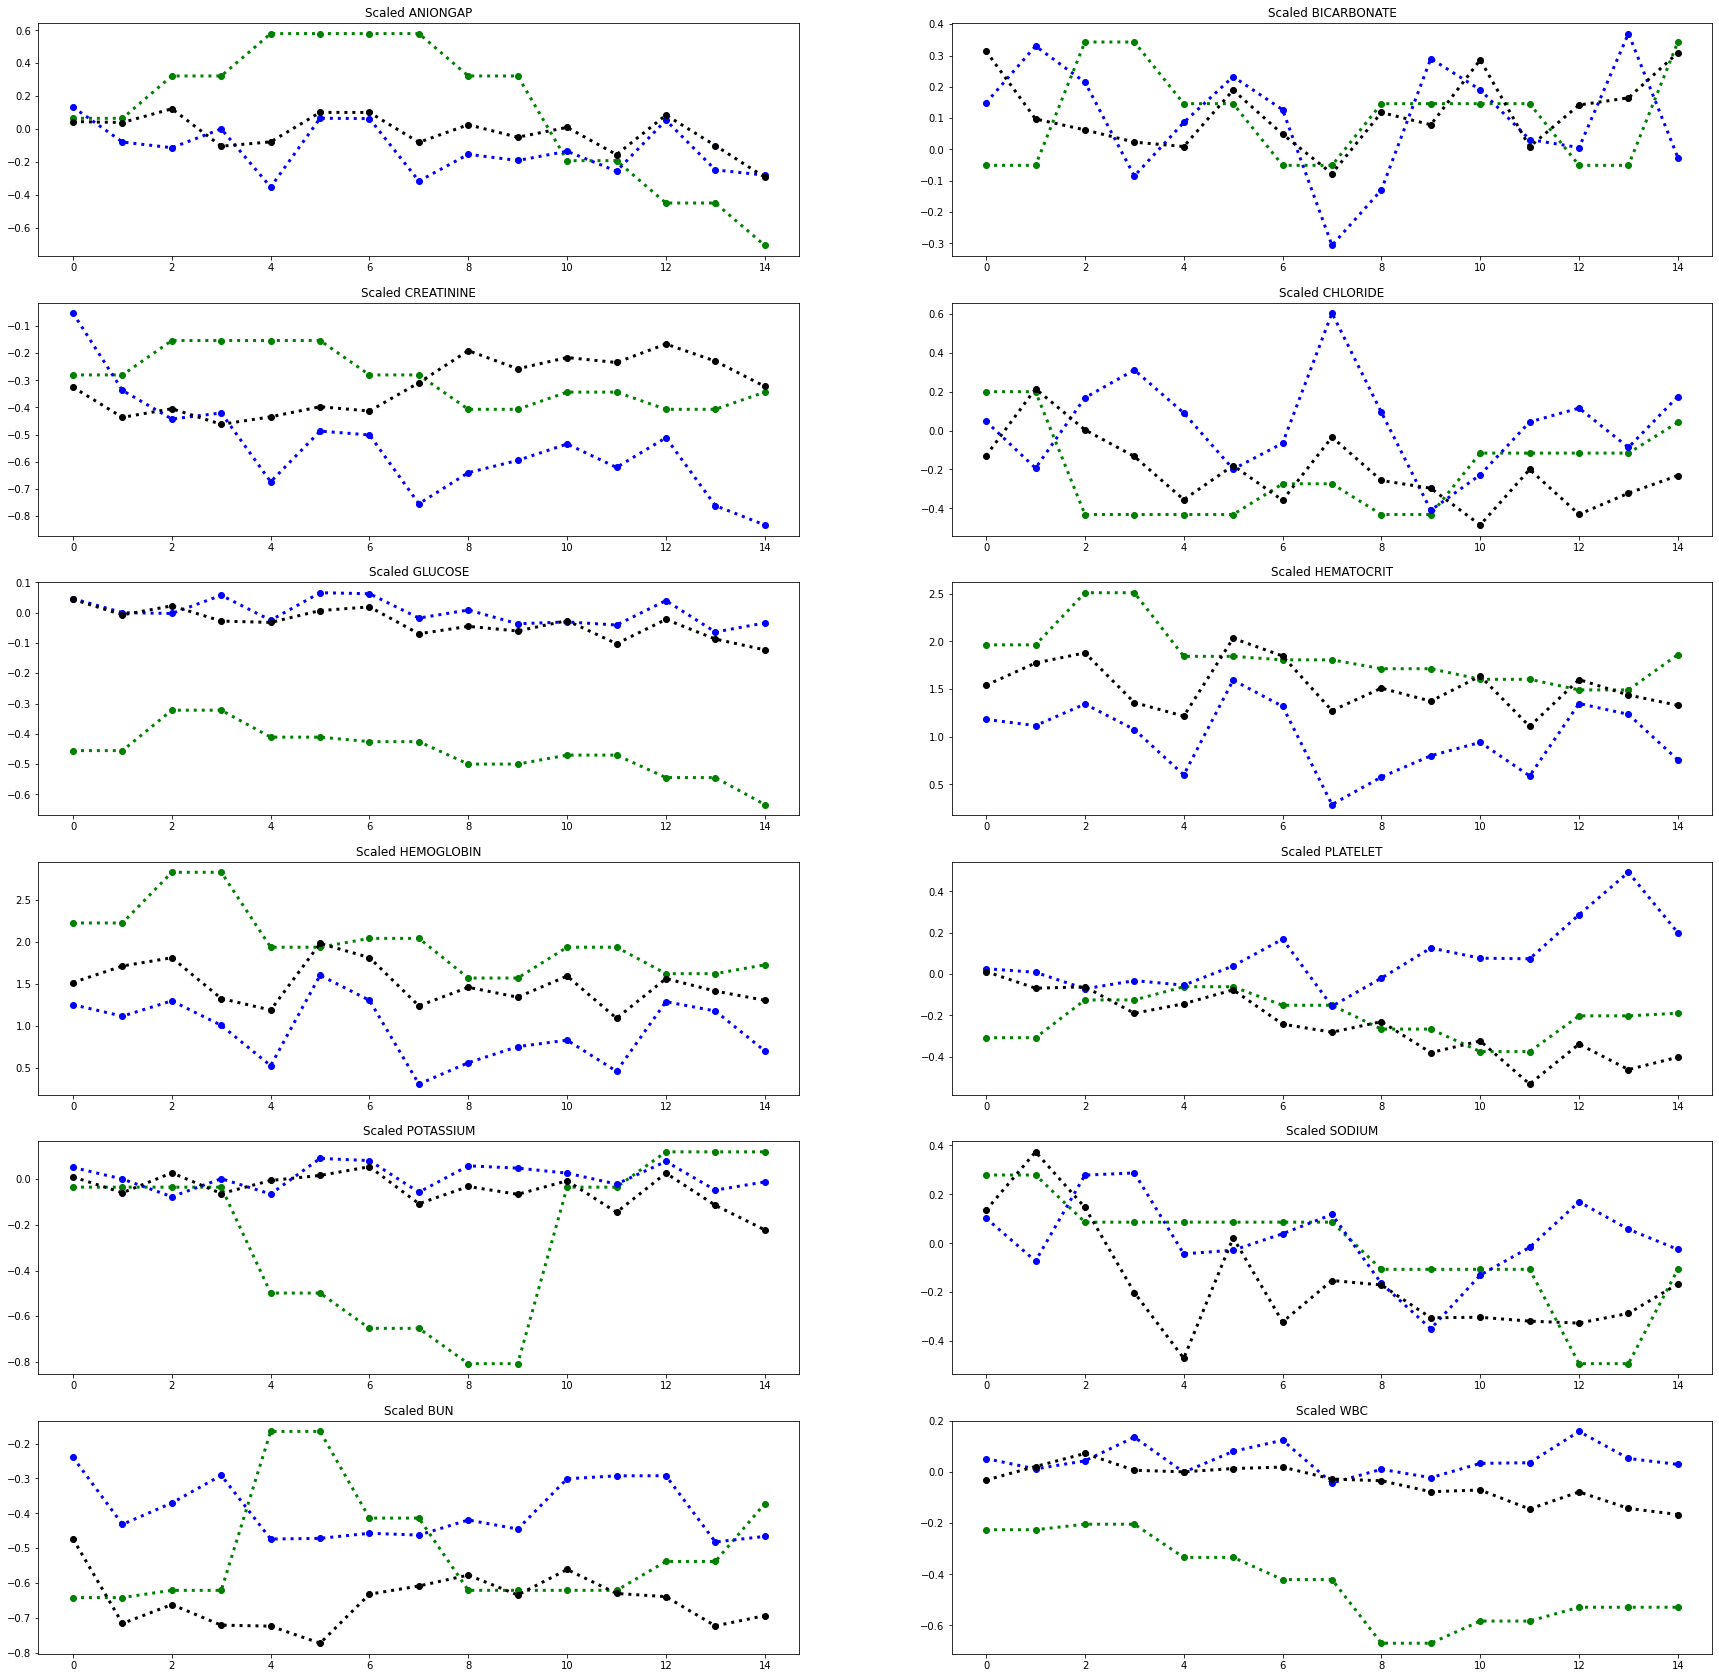

In [185]:
plot_labs(labs_og_5,labs_5,out5,out_5_1,lens_5)

In [ ]:
['Sclaed '+ k for k in cols]

['Sclaed ANIONGAP',
 'Sclaed BICARBONATE',
 'Sclaed CREATININE',
 'Sclaed CHLORIDE',
 'Sclaed GLUCOSE',
 'Sclaed HEMATOCRIT',
 'Sclaed HEMOGLOBIN',
 'Sclaed PLATELET',
 'Sclaed POTASSIUM',
 'Sclaed SODIUM',
 'Sclaed BUN',
 'Sclaed WBC']

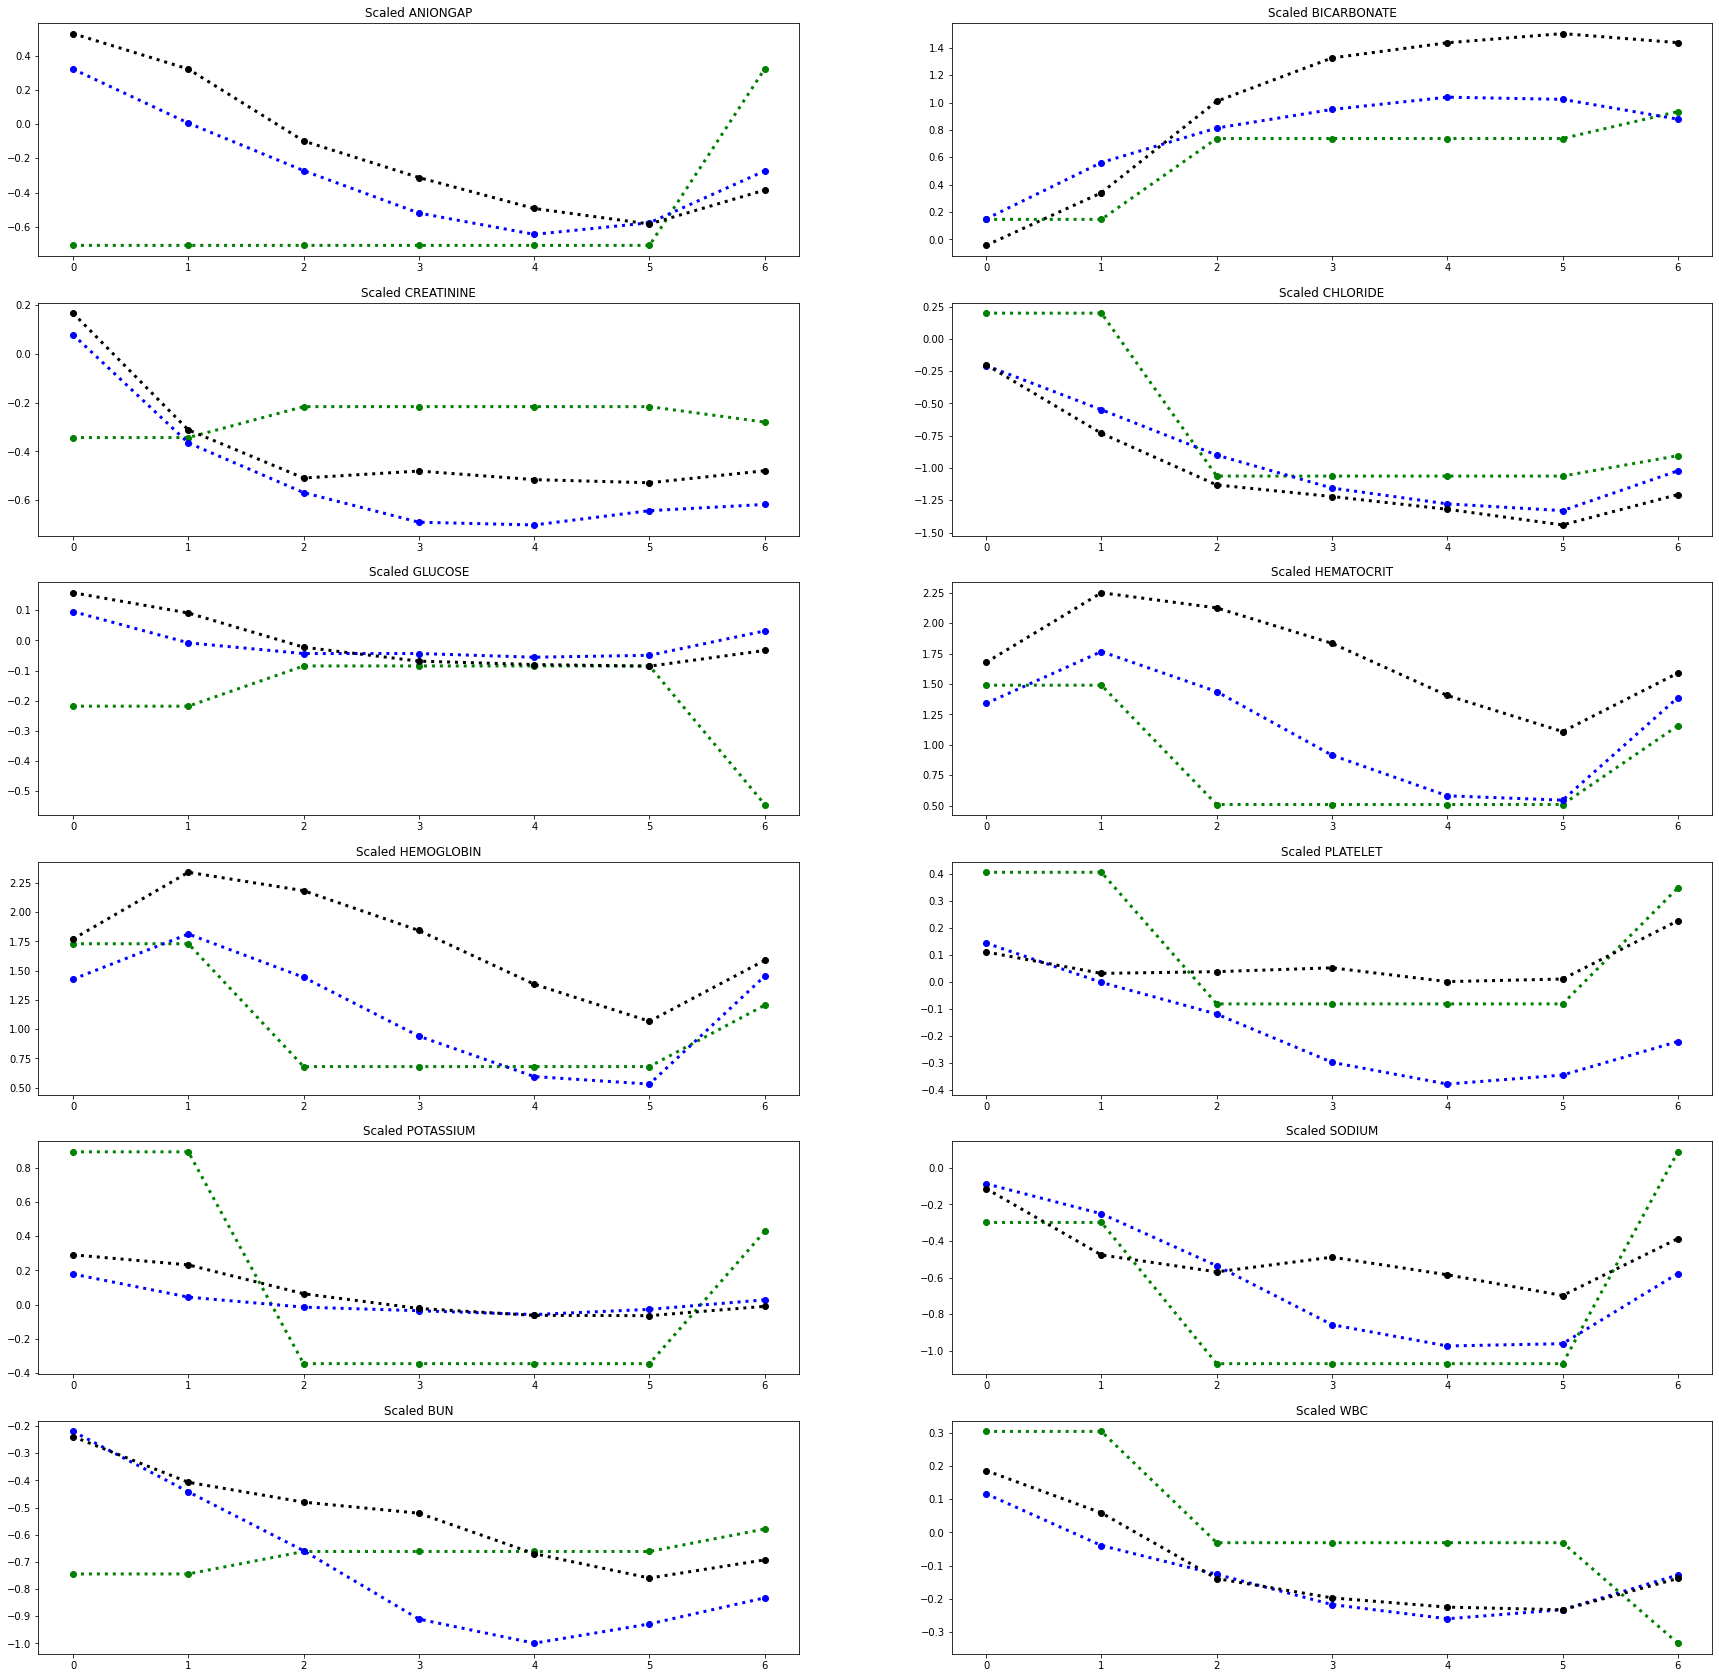

In [ ]:
pat=np.random.choice(np.arange(len(lens_7)))
time_=lens_7[pat]
Titles=['Scaled '+k for k in cols]
fig = plt.figure(figsize=(30,30))
for i in range(1, 13):
    plt.subplot(6, 2, i)
    # ax.scatter(obs1[:,i-1].numpy(),out1[:,i-1].detach().numpy(),marker='x')

    plt.plot(np.arange(lens_7[pat]),labs_7[pat,:time_,i-1].squeeze(0).detach().numpy(),marker='o',color='g',linestyle='dotted',linewidth=3)
    plt.plot(np.arange(lens_7[pat]),out_[pat,:time_,i-1].squeeze(0).detach().numpy(),marker='o',color='b',linestyle='dotted',linewidth=3)
    plt.plot(np.arange(lens_7[pat]),out_7[pat,:time_,i-1].squeeze(0).detach().numpy(),marker='o',color='k',linestyle='dotted',linewidth=3)
    plt.title( Titles[i-1])

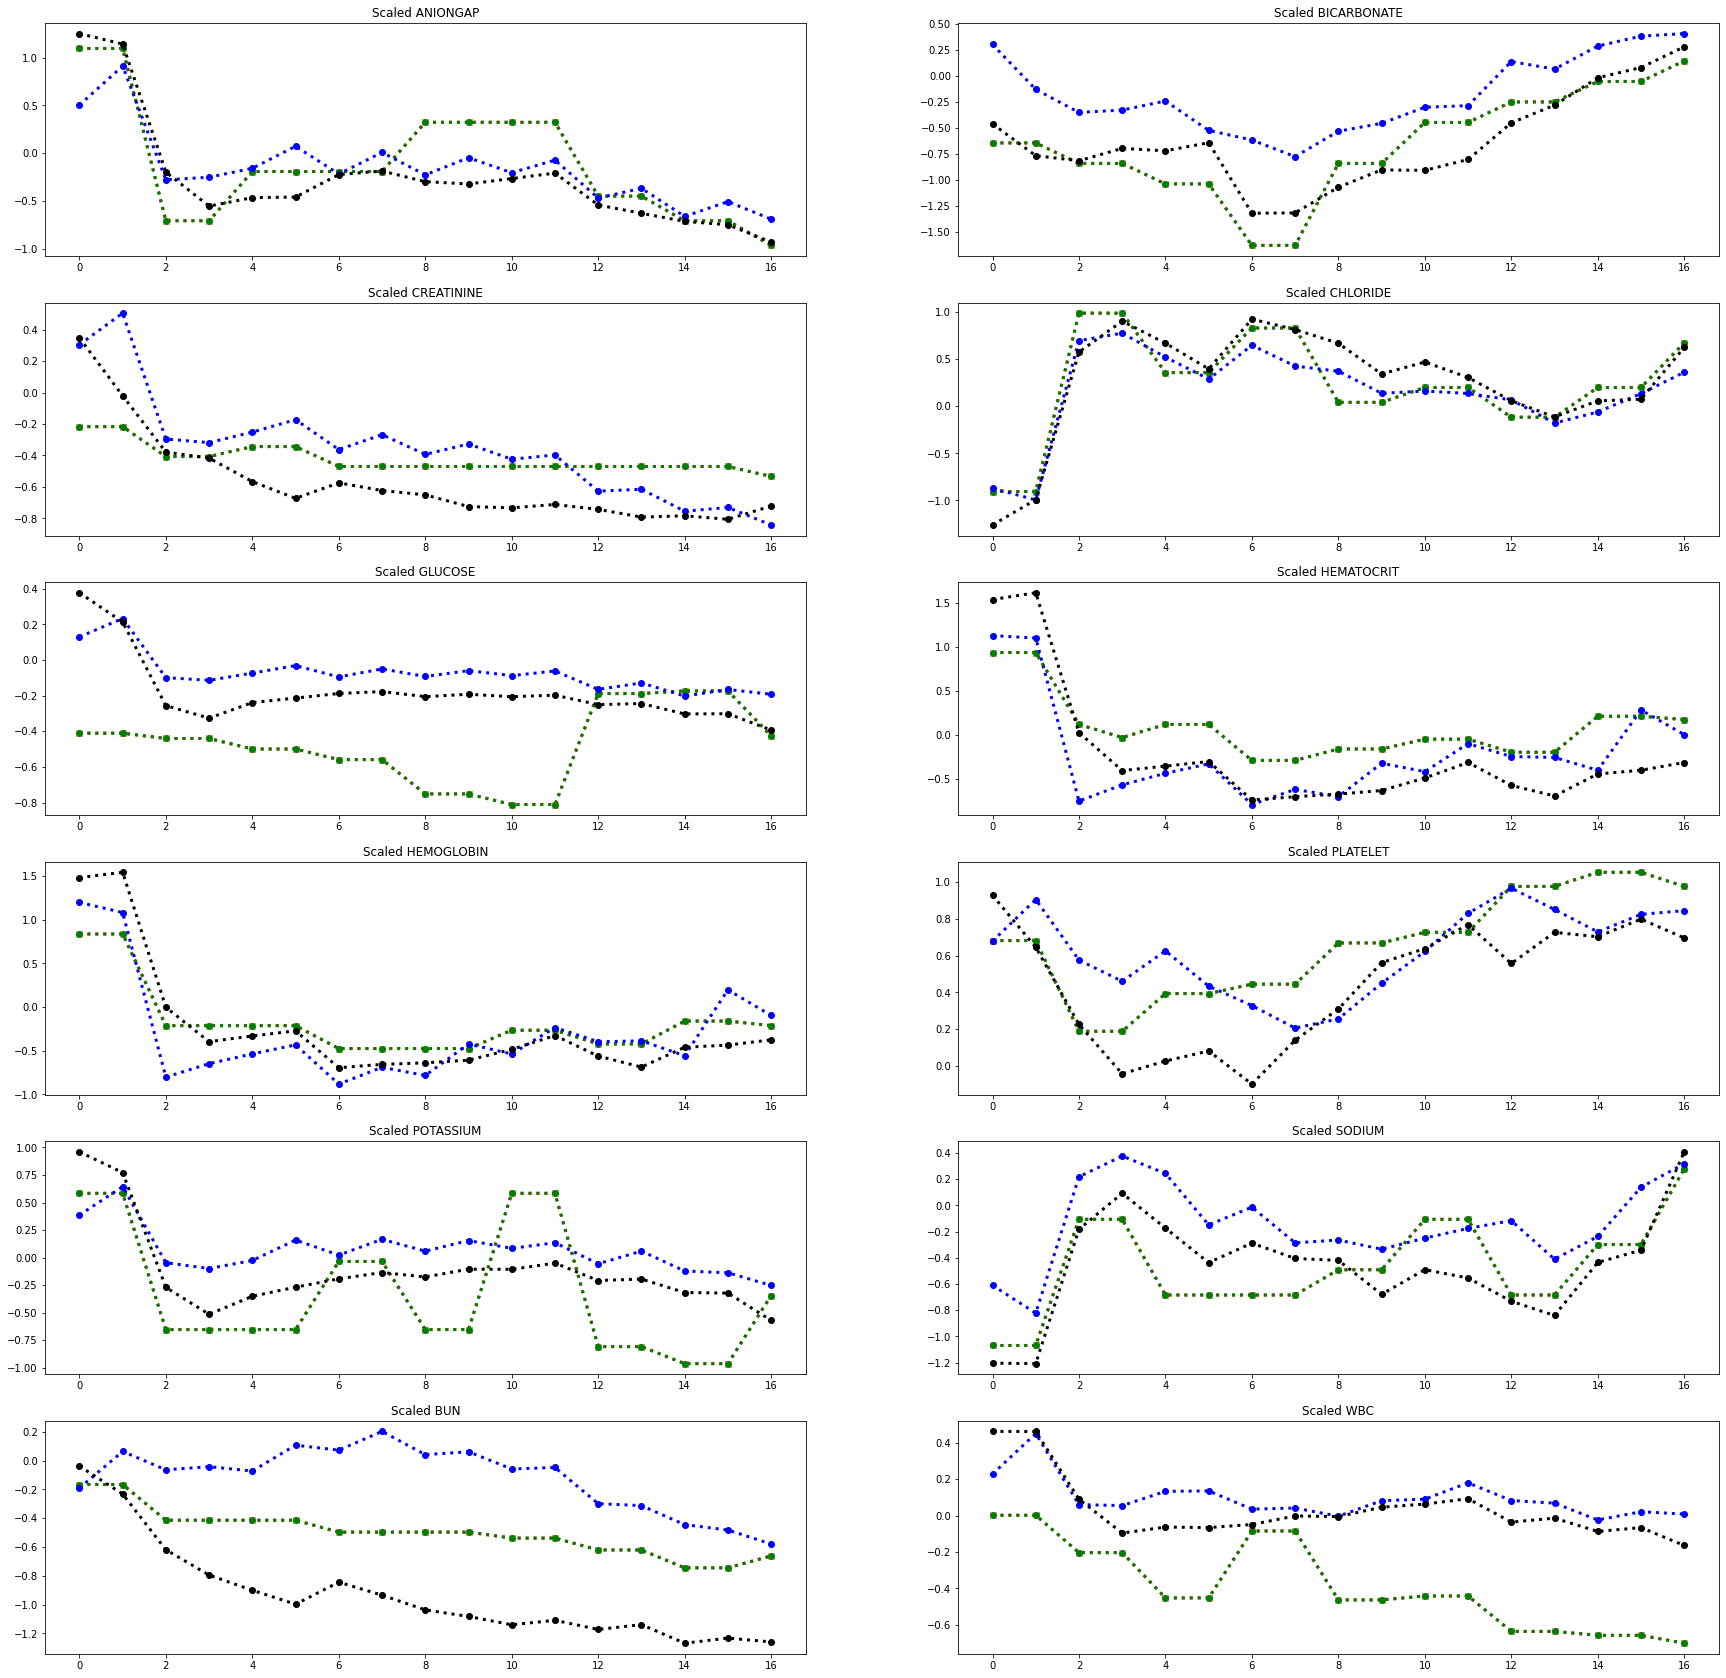

In [ ]:
pat=np.random.choice(np.arange(len(lens)))
time_=lens[pat]
fig = plt.figure(figsize=(30,30))
Titles=['Scaled '+k for k in cols]
for i in range(1, 13):
    plt.subplot(6, 2, i)
    # ax.scatter(obs1[:,i-1].numpy(),out1[:,i-1].detach().numpy(),marker='x')
    plt.plot(np.arange(lens[pat]),labs_og[pat,:time_,i-1].squeeze(0).detach().numpy(),marker='x',color='r',linestyle='dotted',linewidth=3)
    plt.plot(np.arange(lens[pat]),labs_[pat,:time_,i-1].squeeze(0).detach().numpy(),marker='o',color='g',linestyle='dotted',linewidth=3)
    plt.plot(np.arange(lens[pat]),out[pat,:time_,i-1].squeeze(0).detach().numpy(),marker='o',color='b',linestyle='dotted',linewidth=3)
    plt.plot(np.arange(lens[pat]),out_1[pat,:time_,i-1].squeeze(0).detach().numpy(),marker='o',color='k',linestyle='dotted',linewidth=3)
    plt.title(Titles[i-1])

In [ ]:
pat=np.random.choice(np.arange(len(lens_5)))
time_=lens_5[pat]
fig = plt.figure(figsize=(30,30))
for i in range(1, 13):
    plt.subplot(6, 2, i)
    # ax.scatter(obs1[:,i-1].numpy(),out1[:,i-1].detach().numpy(),marker='x')
    plt.plot(np.arange(lens_5[pat]),labs_og_5[pat,:time_,i-1].squeeze(0).detach().numpy(),marker='x',color='r',linestyle='dotted',linewidth=3)
    plt.plot(np.arange(lens_5[pat]),labs_5[pat,:time_,i-1].squeeze(0).detach().numpy(),marker='o',color='g',linestyle='dotted',linewidth=3)
    plt.plot(np.arange(lens_5[pat]),out5[pat,:time_,i-1].squeeze(0).detach().numpy(),marker='o',color='b',linestyle='dotted',linewidth=3)
    plt.plot(np.arange(lens_5[pat]),out_5_1[pat,:time_,i-1].squeeze(0).detach().numpy(),marker='o',color='k',linestyle='dotted',linewidth=3)

In [ ]:
labs_og.shape

torch.Size([16, 162, 12])